# Keras OCR
A packaged and flexible version of the CRAFT text detector and Keras CRNN recognition model

based on the project https://github.com/faustomorales/keras-ocr

> Colab by [mrm8488](https://twitter.com/mrm8488)



In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install pytesseract        # Not used currently
!sudo apt install tesseract-ocr # Not used currently

!pip install keras-ocr
!pip install pyspellchecker
!apt install enchant            # (another dictionnary) Not used currently
!pip install PyEnchant          # Not used currently

  Created wheel for pytesseract: filename=pytesseract-0.3.7-py2.py3-none-any.whl size=13945 sha256=5a374cc97c19c27161e4b57c45927230f7185a3da15ce34fd5c1537aa7ad5a39
  Stored in directory: /root/.cache/pip/wheels/81/20/7e/1dd0daad1575d5260916bb1e9781246430647adaef4b3ca3b3
Successfully built pytesseract
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http:/

Code from *ayesaac\services\optical_character_recognition\bounding_box_to_phrases.py*

In [2]:
import sys
import cv2
import keras_ocr
import argparse
import math
import matplotlib.pyplot as plt
from pprint import pprint
from spellchecker import SpellChecker


def calc_closest_neighbour(data, key, point, dim):
    min_d = sys.maxsize
    closest_n = None
    text = ''
    for n_key in data:
        if n_key != key:
            tmp_dist = math.sqrt(
                (point[0] - data[n_key]['pos'][dim][0]) ** 2 + (point[1] - data[n_key]['pos'][dim][1]) ** 2)
            if tmp_dist <= data[key]['max_dist'][dim] and tmp_dist < min_d:
                min_d = tmp_dist
                closest_n = n_key
                text = data[n_key]['text']

    return {'d': min_d, 'key': closest_n, 'text': text}


def calc_dist_btw_boxes(data):
    for key in data:
        data[key]['closest'] = {'L': calc_closest_neighbour(data, key, data[key]['pos']['L'], 'R'),
                                'R': calc_closest_neighbour(data, key, data[key]['pos']['R'], 'L'),
                                'U': calc_closest_neighbour(data, key, data[key]['pos']['U'], 'D'),
                                'D': calc_closest_neighbour(data, key, data[key]['pos']['D'], 'U')
                                }
    return data


def get_idx_from_key(all, key):
    for i, x in enumerate(all):
        if key == x[0]:
            return i
    return -1


def lines_to_phrases(link, all):
    change = False
    idx = 0
    while idx < len(link):
        i = get_idx_from_key(all, link[idx][0])
        ii = get_idx_from_key(all, link[idx][1])
        if i != -1 and ii != -1:
            change = True
            all[i] += all[ii]
            del all[ii]
            del link[idx]
        idx += 1
    return all, change


def lines_only_to_all_text(lines, all):
    # remove all duplicate
    for l in lines:
        for ll in l:
            if ll in all:
                all.remove(ll)
    # add the single word
    for x in all:
        lines.append([x])
    # sort by y-axis top to bottom
    lines.sort(key=lambda r: int(r[0]))
    return lines


def lines_creator(link):
    """
    B...A + C...B => C...B...A
    A...B + B...C => A...B...C
    """
    change = False
    i = 0
    while i < len(link):
        for ii in range(len(link)):
            if i != ii:
                if link[i][-1] == link[ii][0]:
                    change = True
                    for x in link[ii][1:]:
                        link[i].append(x)
                    del link[ii]
                    break
                elif link[i][0] == link[ii][-1]:
                    change = True
                    for x in link[i][1:]:
                        link[ii].append(x)
                    del link[i]
                    break
        i += 1
    return link, change


def link_by_directions(graph, direction, opposite_direction):
    link = []

    for a, b in graph[direction]:
        for c, d in graph[opposite_direction]:
            if (a == c or a == d) and (b == c or b == d):
                link.append([a, b])

    return link


def words_to_lines(nodes, links):
    lines = link_by_directions(links, 'R', 'L')

    change = True
    while change:
        lines, change = lines_creator(lines)

    lines = lines_only_to_all_text(lines, nodes)

    return lines


def search_links_btw_word(data):
    directions = ['U', 'D', 'L', 'R']
    link = {'U': [], 'D': [], 'L': [], 'R': []}
    for key in data:
        for d in directions:
            if data[key]['closest'][d]['key'] is not None:
                link[d].append([key, data[key]['closest'][d]['key']])
    return link


def init(texts):
    data = {}
    for idx, (text, bbox) in enumerate(texts):
        if not len(text):
            continue
        data[str(idx)] = {'text': text,
                          'bbox': bbox,
                          'max_dist': {'R': (((bbox[1][0] - bbox[0][0]) / len(text)) + (
                                      (bbox[2][0] - bbox[3][0]) / len(text))) / 2,
                                       'L': (((bbox[1][0] - bbox[0][0]) / len(text)) + (
                                                   (bbox[2][0] - bbox[3][0]) / len(text))) / 2,
                                       'D': ((bbox[3][1] - bbox[0][1]) + (bbox[2][1] - bbox[1][1])) / 2,
                                       'U': ((bbox[3][1] - bbox[0][1]) + (bbox[2][1] - bbox[1][1])) / 2
                                       },
                          'pos': {'L': [(bbox[3][0] + bbox[0][0]) / 2, (bbox[3][1] + bbox[0][1]) / 2],
                                  'R': [(bbox[2][0] + bbox[1][0]) / 2, (bbox[2][1] + bbox[1][1]) / 2],
                                  'U': [(bbox[1][0] + bbox[0][0]) / 2, (bbox[1][1] + bbox[0][1]) / 2],
                                  'D': [(bbox[2][0] + bbox[3][0]) / 2, (bbox[2][1] + bbox[3][1]) / 2]},
                          'key': str(idx)
                          }

    data = calc_dist_btw_boxes(data)
    return data


def bb_to_text(predictions, correction):
    data = init(predictions)
    nodes = [data[x]['key'] for x in data]
    links = search_links_btw_word(data)

    lines = words_to_lines(nodes, links)
    lines_link = link_by_directions(links, 'D', 'U')

    change = True
    while change:
        lines, change = lines_to_phrases(lines_link, lines)

    spell = SpellChecker(distance=1)
    text = []
    for l in lines:
        phrase = []
        for ll in l:
          if correction == True:
            phrase.append(spell.correction(data[ll]['text']))
          else:
            phrase.append(data[ll]['text'])
        text.append(phrase)
    return text

code from *ayesaac\services\optical_character_recognition\main.py*

In [3]:
import numpy as np

#from ayesaac.services.common import QueueManager
#from ayesaac.services.common.crypter import decode
#from ayesaac.utils.logger import get_logger

#from .bounding_box_to_phrases import bb_to_text

class OCR(object):
    """
    The class OCR purpose is to detect all the possible text in the picture.
    """

    def __init__(self):
        self.pipeline = keras_ocr.pipeline.Pipeline()

    def run(self, image):
        predictions = self.pipeline.recognize(image)[0]

        """fig, axs = plt.subplots(nrows=len(image), figsize=(20, 20))
        keras_ocr.tools.drawAnnotations(image=image[0], predictions=predictions, ax=axs)
        plt.show()"""
        # pprint(predictions)
        # text = bb_to_text(predictions, False)

        #pprint(text)
        return(predictions)

code from *ayesaac\services\optical_character_recognition\skew_correction.py*

In [4]:
#SOURCE CODE : https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df

# Calculate skew angle of an image
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle

In [5]:
## Source code: https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point

import numpy as np
import cv2

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

# Reading an image

In [6]:
pathToImage = "img2.jpg"

# Image loading
images = []
images.append(cv2.imread(pathToImage))

# OCR Run with 90° rotations



Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5
'I cannot read this confidently, try reorientating the object.'
'Reading successfully.'


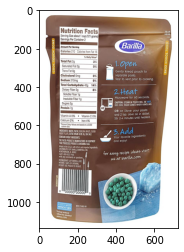

In [8]:
attempt = 0
ocrCleanText = None
noSkewimages = []
noSkewimages.append(None)

ocr = OCR()

while (attempt < 4):
  # Skew correction (USELESS?)
  noSkewimages[0] = rotate_image(images[0], -getSkewAngle(images[0]))

  # OCR running
  ocrPrediction = ocr.run(noSkewimages)

  ocrRawText = bb_to_text(ocrPrediction, False)

  # Approximate confidence rating
  spell = SpellChecker()
  nbTotalWords = 0;
  nbCorrectWords = 0;

  for j in range(0, len(ocrRawText)):
    nbTotalWords = nbTotalWords + len(ocrRawText[j]);
    nbCorrectWords = nbCorrectWords + len(spell.known(ocrRawText[j]))

  percentage = nbCorrectWords/nbTotalWords * 100

  if( percentage < 50 ):
    pprint("I cannot read this confidently, try reorientating the object.") # TODO: check use pprint or logger?
    images[0] = np.rot90(images[0])
    attempt = attempt + 1
  else: 
    pprint("Reading successfully.") # TODO: check use pprint or logger?
    ocrCleanText = bb_to_text(ocrPrediction, True);
    attempt = 4;

plt.imshow(images[0])